# Treating the range estimates #

In [one of the previous notebooks](agile_estimation_2.ipynb)we have established a statistical model for predicting the actual project time and cost based on the estimates. We discussed that we can fit the estimates (both for the Agile and Waterfall projects) to a Log-Normal distribution, which guarantees the positive support. Using statistical approach to estimation allows us to give prediction with a required confidence level, and also project monetary benefits, costs and risk, as we discussed in [another notebook](agile_estimation_3.ipynb).

One thing I was asked is how the model generalizes for the case when an estimate is given as a range. Indeed, this is what everybody taught us: do not give a single number, but range. One approach is to continue to use our statistical model, and feed it a number in the middle, the mean of the two values. 

$$x = \frac{high+low}{2}$$

That way the model can be used without modifications.

There are two problems with this approach: 
1. Taking a mean of high and low is arbitrary. It reduces the information given by half. It would be better to have an algorithm learn where we need to set the variable x within the interval between low and high boundaries
2. By giving us a range of data, a developer is trying to convey to us a very important information: a degree of uncertainty in the estimates. A correct model should use that information.

To simplify the process, we will take natural logarithm of all the estimates and the actuals. Since we model estimates using log-normal distribution, our new variables `y`, `l`, `h` will be logarithms of the actual number of days, low and high estimates respectively. In this case we can use Normal distribution!
We will model `y` using linear regression:
$$ y = \theta_h h + \theta_l l $$

In case where $\theta_h$ and $\theta_l$ are equal, we get exactly the same problem as we discussed [earlier](agile_estimation_2.ipynb).

The likelihood function for a single piece of data in this case can be written as follows (following [this](https://en.wikipedia.org/wiki/Bayesian_linear_regression)). 

$$ \rho(y|h,l,\theta_h, \theta_l, \sigma) \propto \frac{1}{\sigma} \exp(-\frac{1}{2\sigma^2}(y - \theta_h h - \theta_l l)^2 )$$

As mentioned earlier, by giving a range, the developer wanted to communicate to us the uncertainty of the estimate. We should include this uncertainty in our estimate of $\sigma$. Intuitively the range is proportional to the standard deviation, and we can learn the coefficient by modeling $\sigma$ as:
$$\sigma = \sigma_0 (1 + \zeta^2 (h-l))$$

If we also use precision parameter $\tau$ in place of $\sigma_0$:
$$\tau = \frac{1}{\sigma^2}$$

Then our likelihood function will be:
$$ \rho(y|h,l,\theta_h, \theta_l, \tau, \zeta) \propto \frac{\sqrt{\tau}}{1 + \zeta^2 (h-l)} \exp(-\frac{\tau}{2(1 + \zeta^2 (h-l))^2}(y - \theta_h h - \theta_l l)^2 )$$
    

The priors for $\tau$ and $\theta$ are traditionally Gamma and Normal distribution respectively:

$$\rho(\tau) \propto \tau^{\alpha-1}e^{-\beta \tau}$$

$$\rho(\theta|\tau) \propto \tau \exp(-\frac{\tau \lambda}{2}(\theta_h^2+\theta_l^2))$$

Here $\alpha$, $\beta$, $\lambda$ are hyperparameters

The choice of prior for $\zeta$ is more difficult. None of the conjugate priors exist for the kind of likelihood function we have chosen. For now we can select the normal distribution. Zero mean of this distribution means that a priori we don't trust the ranges (we know that many consultants the range is always 20% and does not convey any information). High mean of the prior distribution means that we pay more attention to the estimated degree of uncertainty.

For simplicity  we set the mean to zero.

$$\rho(\zeta) \propto \sqrt{\tau} \exp(-\frac{\tau \lambda_\zeta}{2}\zeta^2)$$

The negative log-posterior function is:
$$ \mathscr{L}(\theta_h, \theta_l,\zeta, \tau) = \sum_{i=0}^{N-1}[\log(1 + \zeta^2 (h^{(i)}-l^{(i)})) +
\frac{\tau}{2(1 + \zeta^2 (h^{(i)}-l^{(i)}))^2}(y - \theta_h h^{(i)} - \theta_l h^{(i)})^2 ]
- \frac{N+1+2\alpha}{2}\log{\tau} + \beta \tau + \frac{\tau \lambda}{2}(\theta_h^2+\theta_l^2))
+ \frac{\tau \lambda_\zeta}{2}\zeta^2
$$ 

In this notebook I will find parameters, corresponding to the maximum posterior. And to avoid making errors in differentiating, we will use TensorFlow. We will follow [this example](https://github.com/tensorflow/tensorflow/blob/r1.11/tensorflow/examples/get_started/regression/custom_regression.py) to build our code

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

The data here represent the estimated and actual number of days. We see that the developer liked to add 25% to his estimate as a buffer.However for some of the stories he added more buffer, perhaps, to indicate more uncertainty.

In [6]:
seed=1389
tf.reset_default_graph()
task_data = pd.DataFrame({'low':[4,14,4,3,4,3,4,9,6,27,20,23,11],
                          'high':[5,18,5,4,5,7,5,10,8,30,25,29,14],
                          'actual':[17,8,5,3,5,4,9,9,4,27,16,15,7,]})
task_data

,low,high,actual
0,4,5,17
1,14,18,8
2,4,5,5
3,3,4,3
4,4,5,5
5,3,7,4
6,4,5,9
7,9,10,9
8,6,8,4
9,27,30,27


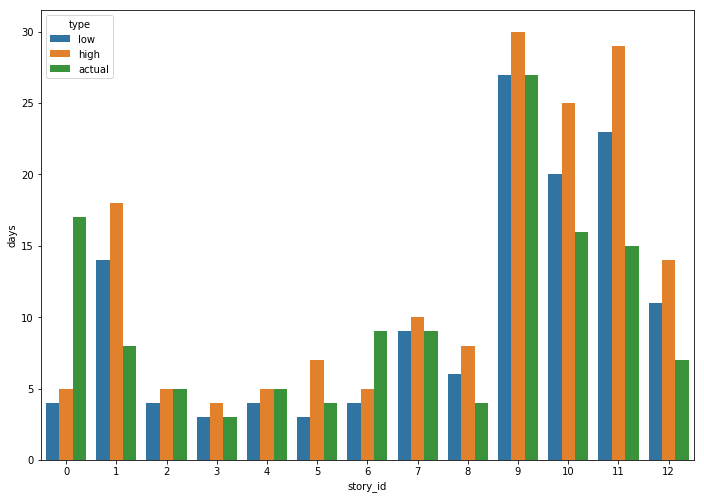

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(11.7, 8.27))
task_data['story_id'] = task_data.index
data_for_plot = pd.melt(task_data, id_vars="story_id", var_name="type", value_name="days")
task_data.drop(columns=['story_id'], inplace=True)
sns.barplot(x='story_id', y='days', hue='type', data=data_for_plot,ax=ax);

When defining variables, we substitute $\tau$ for another variable $\rho$:
$$ \tau = \rho^2 $$
This is to avoid the optimizer selecting negative $\tau$

In [8]:
#Taking the log of data
log_data = np.log(task_data.values)
N = log_data.shape[0]

#Defining variables
theta_h = tf.Variable(name='theta_h', initial_value=0.5)
theta_l = tf.Variable(name='theta_l', initial_value=0.5)
zeta = tf.Variable(name='zeta', initial_value=0.01)
rho = tf.Variable(name='rho', initial_value=0.01) 

Since we don't want to tune too many hyperparameters, we will set $\alpha$ and $\beta$ to one. Both $\lambda$ parameters act as regularization parameters, so we will have to tune them

In [9]:
#Set the hyperparameters
alpha = tf.constant(name='alpha', value=1.0)
beta = tf.constant(name='beta', value=1.0)
lambda1 = tf.constant(name='lambda1', value=1e-4)
lambda2 = tf.constant(name='lambda2', value=1e-4)


In [10]:
def loss(l, h, y):
    return tf.log(1+zeta**2*(h-l)) + \
        rho**2/2/(1+zeta**2*(h-l))**2 * (y - theta_l*l - theta_h*h)**2

In [11]:
cummulative_loss = tf.reduce_sum(list(np.apply_along_axis(lambda x: loss(*x), axis=1, arr=log_data )))
cost = cummulative_loss - (N+1-2*alpha)/2*tf.log(rho**2) + beta*rho**2 + \
rho**2*lambda1/2*(theta_h**2+theta_l**2) + rho**2*lambda2/2*zeta**2

In [12]:
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(cost)

In [13]:
import math
init = tf.global_variables_initializer()
n_epochs = int(1e5)


with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 1e4 == 0:
            print("Epoch", epoch, "Cost =", cost.eval())
            print(f'Parameters: {theta_l.eval()}, {theta_h.eval()}, {rho.eval()}, {zeta.eval()}')
        sess.run(train_op)
    best_theta_l = theta_l.eval()
    best_theta_h = theta_h.eval()
    best_sigma = 1/math.sqrt(rho.eval())    


Epoch 0 Cost = 55.26268
Parameters: 0.5, 0.5, 0.009999999776482582, 0.009999999776482582
Epoch 10000 Cost = 6.5892615
Parameters: 0.24855799973011017, 0.6630115509033203, 0.6332486271858215, 1.1534561276317736e-35
Epoch 20000 Cost = 1.39517
Parameters: 0.2485545128583908, 0.6630078554153442, 1.3754394054412842, 1.1534561276317736e-35
Epoch 30000 Cost = 1.3396643
Parameters: 0.24855604767799377, 0.6630094647407532, 1.4745615720748901, 1.1534561276317736e-35
Epoch 40000 Cost = 1.3396641
Parameters: 0.24855272471904755, 0.6630063056945801, 1.4745622873306274, 1.1534561276317736e-35
Epoch 50000 Cost = 1.3396646
Parameters: 0.2485586702823639, 0.6630119681358337, 1.4745632410049438, 1.1534561276317736e-35
Epoch 60000 Cost = 1.3396648
Parameters: 0.2485581487417221, 0.6630115509033203, 1.4745649099349976, 1.1534561276317736e-35
Epoch 70000 Cost = 1.3396643
Parameters: 0.2485586702823639, 0.6630122065544128, 1.4745644330978394, 1.1534561276317736e-35
Epoch 80000 Cost = 1.3396643
Parameters: 0

What is interesting here is that $\zeta$ is zero. This means that we cannot trust the estimation of uncertainty that the developers give us. This also means that we can just use log-normal distribution around the mean specified by the learned parameters $\theta_l$ and $\theta_h$. Let's say, the same developer estimated a new task to take 10-15 days. Plugging it into the formulas we see:

In [14]:
mu = best_theta_l*math.log(10)+best_theta_h*math.log(15)
most_likely_prediction = math.exp(mu)    
most_likely_prediction

10.67385532327305

We can also get the 95% confidence, by plugging the values directly into log-normal distribution:

In [15]:
from scipy.stats import lognorm
distribution = lognorm(s=best_sigma, scale=most_likely_prediction, loc=0)
print(f'95% confidence: {distribution.ppf(0.95)}')

95% confidence: 41.3614192940211


As we see, if we want 95% of confidence, we have to give an estimate of 41 days, instead of 11 days for 50% confidence. This is very easily explained if you see that in the past the developer did not do a very good job estimating the tasks.